# Session 4: Classification + Clustering  
## Knowing What Question You Are Actually Asking

So far, we predicted a number (house price).
That was **regression**.

Now we look at two other types of questions:
- Classification
- Clustering

The most important skill here is **choosing the right problem type**.
Using the wrong one gives confident but useless answers.

---

## Part 1: Classification — Predicting Categories

### What is classification?

Classification answers questions like:
- Is this house expensive or not?
- Will this customer churn or stay?
- Is this transaction fraud or not?

The output is a **label**, not a number.

---

### Binary vs Multiclass

**Binary classification**
- Two outcomes
- Examples:
  - Expensive vs Not Expensive
  - Yes vs No

**Multiclass classification**
- More than two outcomes
- Examples:
  - Cheap / Medium / Expensive
  - Low / Medium / High risk

In this session, we only do **binary**.

---

### Accuracy is NOT enough (important)

Accuracy answers:
> “What percentage did we get right?”

This can be misleading.

Example:
- 95% of houses are “Not Expensive”
- A model that always predicts “Not Expensive”
- Accuracy = 95%
- Model = useless

This is why we also care about:
- Precision → “When I say Expensive, how often am I right?”
- Recall → “Of all expensive houses, how many did I catch?”

No math today. Just intuition.

---

### Models we use (conceptually)

**Logistic Regression**
- Linear model for classification
- Outputs probability (0–1)
- Simple, interpretable, strong baseline

**Decision Trees**
- Rule-based (“if–then” splits)
- Easy to understand
- Prone to overfitting if not controlled

We will *train* Logistic Regression.
Trees are for understanding concepts.

---

## Part 2: Clustering — Finding Structure Without Labels

### What is clustering?

Clustering answers:
> “What natural groups exist in this data?”

There is:
- No target
- No correct answer
- Only patterns

---

### Why clustering exists

Clustering is used for:
- Market segmentation
- Customer grouping
- Exploratory analysis

It does NOT:
- Predict outcomes
- Guarantee usefulness
- Create truth

---

### K-Means (intuition)

K-Means:
- You choose **K** (number of clusters)
- Algorithm groups points by similarity
- Tries to minimize distance within clusters

Important:
> The algorithm will always return clusters — even if they make no sense.

---

### When clustering is NOT appropriate

Clustering is a bad idea when:
- You already have labels
- You don’t know what decision the clusters support
- You plan to treat clusters as truth

Rule:
> Unsupervised ≠ useful by default.

---

## Key takeaway for this session

Before choosing a model, ask:
- Do I have a target?
- Am I predicting a number or a category?
- Do I want prediction or discovery?

Most ML mistakes are **problem framing mistakes**, not algorithm mistakes.


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("house_prices.csv")
df.head()

,Id,Neighborhood,YearBuilt,LotArea,OverallQual,GrLivArea,FullBath,GarageCars,Fireplaces,CentralAir,KitchenQual,DistanceToCityCenterKm,SaleCondition,SalePrice
0,1,Edwards,1987,5405.0,1,1981,2,0.0,0,Y,TA,2.73,Normal,230100
1,2,Mitchel,1968,7515.0,8,1138,1,2.0,2,Y,TA,6.75,Normal,267240
2,3,Crawfor,1966,5897.0,7,1073,2,1.0,0,Y,Gd,13.85,Normal,283400
3,4,Somerst,1972,25261.0,5,1730,2,0.0,1,Y,TA,5.09,Normal,347970
4,5,NAmes,1992,7649.0,5,1994,2,1.0,2,Y,TA,5.61,Normal,307380


In [2]:
# Create binary target
median_price = df["SalePrice"].median()

df["IsExpensive"] = (df["SalePrice"] > median_price).astype(int)

df[["SalePrice", "IsExpensive"]].head()


,SalePrice,IsExpensive
0,230100,0
1,267240,0
2,283400,1
3,347970,1
4,307380,1


In [3]:
# Drop original price (target leakage)
X = df.drop(columns=["SalePrice", "IsExpensive"])
y = df["IsExpensive"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keep class balance
)

X_train.shape, y_train.mean()


((1200, 13), np.float64(0.5))

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

numeric_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(exclude=np.number).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [5]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

clf.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9066666666666666
              precision    recall  f1-score   support

           0       0.90      0.91      0.91       150
           1       0.91      0.90      0.91       150

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



### What do these classification results mean?

This model is answering a **yes / no question**:

> “Is this house expensive compared to others?”

Here:
- **Class 1** = Expensive  
- **Class 0** = Not Expensive

---

## Overall Accuracy: ~91%

**Accuracy = 0.91** means:

> Out of every 100 houses, the model correctly classifies about **91** of them.

This sounds good — but accuracy alone can be misleading.
That’s why we look deeper.

---

## Precision — “When the model says ‘Expensive’, is it right?”

For class **1 (Expensive)**:
- Precision ≈ **0.91**

Meaning:
> When the model predicts a house is expensive, it is correct **91% of the time**.

High precision means:
- Few false alarms
- We don’t label cheap houses as expensive too often

---

## Recall — “Did the model catch the expensive houses?”

For class **1 (Expensive)**:
- Recall ≈ **0.90**

Meaning:
> Out of all truly expensive houses, the model correctly identifies about **90%** of them.

High recall means:
- The model misses very few expensive houses
- Only ~10% slip through as “not expensive”

---

## Precision vs Recall (important intuition)

- **Precision** cares about *being right when you say “yes”*
- **Recall** cares about *not missing true cases*

Trade-off example:
- High precision, low recall → very strict model
- High recall, low precision → very generous model

Here:
- Precision and recall are balanced
- No obvious trade-off problem

---

## F1-Score — “One number to summarize both”

F1-score ≈ **0.91** combines:
- Precision
- Recall

It is high only when **both** are high.

This confirms:
- The model is not cheating by favoring one at the expense of the other

---

## Support — “How much data is behind these numbers?”

Support = **150 for each class**

Meaning:
- The dataset is perfectly balanced
- 150 expensive houses
- 150 not-expensive houses

This is important:
> Accuracy is trustworthy here because classes are balanced.

---

## Macro vs Weighted Averages

- **Macro avg**
  - Treats both classes equally
- **Weighted avg**
  - Accounts for how many examples each class has

Because classes are balanced:
- Macro ≈ Weighted ≈ Accuracy

This is what we want to see.

---

## Final Interpretation (plain language)

This classification model:
- Correctly labels about **9 out of 10 houses**
- Is equally good at finding expensive and non-expensive houses
- Does not strongly favor one class over the other
- Generalizes well to unseen data

---

## Important warning (do NOT skip this)

These results look good **because the problem is simple**:
- Target was defined using the median
- Classes are clean and balanced
- Features are strongly related to price

In real-world classification:
- Classes are often imbalanced
- Labels are noisy
- Accuracy drops quickly

Rule to remember:
> Good metrics on a simple problem do not guarantee success on harder ones.

In [7]:
# clustering
cluster_features = df[["GrLivArea", "OverallQual", "SalePrice"]].dropna()

from sklearn.preprocessing import StandardScaler
X_cluster = StandardScaler().fit_transform(cluster_features)

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_cluster)

cluster_features["Cluster"] = clusters
cluster_features.head()


,GrLivArea,OverallQual,SalePrice,Cluster
0,1981,1,230100,0
1,1138,8,267240,2
2,1073,7,283400,2
3,1730,5,347970,1
4,1994,5,307380,1


### What did clustering actually do?

The algorithm grouped houses by similarity.
It did NOT:
- Discover truth
- Find “real” categories
- Explain why groups exist

Clusters are:
- A starting point for questions
- Not an answer by themselves

---

### When is clustering useful?

Clustering is useful when:
- You want to segment data
- You plan different actions per cluster
- You validate clusters with domain knowledge

---

### When is clustering dangerous?

Clustering is dangerous when:
- You treat clusters as ground truth
- You don’t know how they’ll be used
- You skip validation

Rule:
> Unsupervised learning creates structure.  
> Humans must create meaning.


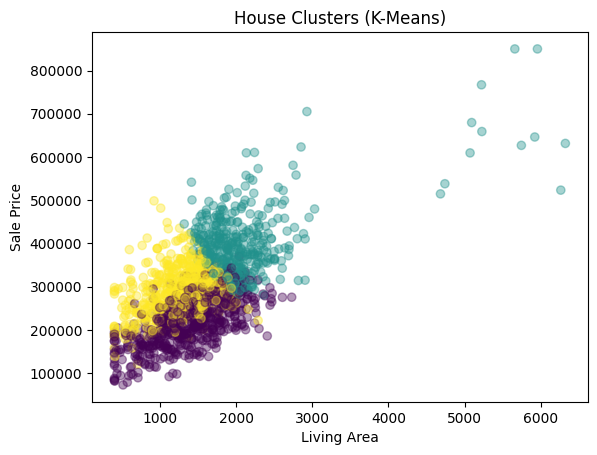

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    cluster_features["GrLivArea"],
    cluster_features["SalePrice"],
    c=cluster_features["Cluster"],
    alpha=0.4
)
plt.xlabel("Living Area")
plt.ylabel("Sale Price")
plt.title("House Clusters (K-Means)")
plt.show()

### What is this clustering plot showing?

Each point represents **one house**.

- **X-axis:** Living Area (size of the house)
- **Y-axis:** Sale Price
- **Color:** Cluster assigned by K-Means

The colors were assigned automatically by the algorithm.
They are just labels: Cluster 0, Cluster 1, Cluster 2.
They do NOT have inherent meaning.

---

### What did K-Means actually do?

K-Means:
- Looked only at the numeric features we gave it
- Grouped houses that are **similar to each other**
- Minimized distance *within* each group

Important:
> The algorithm does NOT know what a “cheap” or “luxury” house is.  
> It only knows numbers and distances.

---

### How should we interpret these clusters?

Visually, the clusters roughly correspond to:
- Smaller / cheaper houses
- Medium-sized / mid-priced houses
- Larger / more expensive houses

This makes intuitive sense **because price and size are strongly related**.

However:
- The algorithm did not discover this meaning
- We are interpreting it after the fact

Rule:
> Clusters do not come with explanations.  
> Humans must explain them.

---

### What clusters do NOT mean (very important)

Clusters are NOT:
- Ground truth categories
- Real market segments
- Guaranteed to be stable over time
- Automatically useful

The algorithm will always produce clusters,
even if the data has no meaningful structure.

---

### When is clustering actually useful?

Clustering is useful when:
- You want to **segment** data for different actions
- Each cluster leads to a different decision

Examples:
- Different pricing strategies
- Different marketing approaches
- Different risk treatments

Without a decision, clusters are just colors.

---

### What should we do after clustering?

Good next steps:
- Inspect cluster averages (price, size, quality)
- Give clusters descriptive names (after analysis)
- Validate clusters with domain knowledge

Bad next steps:
- Treat clusters as truth
- Use them blindly in production
- Assume they explain causation

---

### Key takeaway (lock this in)

> Clustering creates structure, not meaning.  
> It is a tool for exploration, not an answer by itself.
